# Dataset
In this notebook we'll perform tests on the SIS Dataset.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'../')

from datasets import load_dataset,load_from_disk
from torchvision.transforms import Compose,Resize,ToTensor,Normalize
import numpy as np
hf_dir_path = "/mnt/c/BUSDATA/Datasets/CelebAMask-HQ/hf/"
dataset = load_from_disk(hf_dir_path)

img_size = 256
def transform(examples):
    resize = Resize(img_size)
    transforms_img = Compose([
        resize,
        ToTensor(),
        Normalize(0.5,0.5)
    ])

    examples["image"] = [transforms_img(image.convert("RGB")) for image in examples["image"]]
    examples["annotation"] = [np.array(resize(image)) for image in examples["annotation"]]
    return examples
dataset.set_transform(transform)

/home/f296849/miniconda3/Bib/envs/diffusers_dev/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from examples.community.semantic_image_synthesis.src.pipelines.semantic_only_diffusion import SemanticOnlyDDMPipeline
from examples.community.semantic_image_synthesis.src.models import AutoencoderKL,AutoencoderSIS
#model_dir_path = "/mnt/c/BUSDATA/Datasets/CelebAMask-HQ/models/256x256px/checkpoint-11000"
model_dir_path = "/mnt/c/BUSDATA/Datasets/CelebAMask-HQ/models/vae/256px_64px/sample/test/vae"

vae = AutoencoderKL.from_pretrained(model_dir_path)
vae=vae.to('cuda')


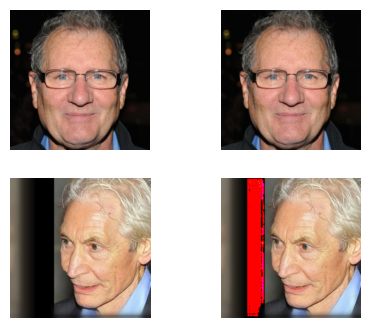

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def to_uint8(tensor:torch.Tensor):
    tensor = tensor.squeeze(0)
    assert len(tensor.shape)==3,"Tensor should be [C,W,H] or [1,C,W,H]"
    tensor = 127.5*(tensor.cpu().permute(1,2,0)+1)
    return tensor.numpy().astype(np.uint8)

test_dataset = dataset['test']
n_samples = 2
fig,ax=plt.subplots(n_samples,2,figsize=(5,n_samples*2))
indexes = torch.randint(0,len(test_dataset),(n_samples,))

for i,index in enumerate(indexes):
    x = test_dataset[int(index)]['image']
    with torch.autocast(device_type="cuda",dtype=torch.float16),torch.no_grad():
        x = x.unsqueeze(0).cuda()
        vae_enc = vae.encode(x).latent_dist
        z = vae_enc.mode()
        #z[:,:,:32,:32]=0
        vae_dec = vae.decode(z)
    ax[i,0].imshow(to_uint8(x))
    ax[i,0].set_axis_off()
    ax[i,1].imshow(to_uint8(vae_dec.sample))
    ax[i,1].set_axis_off()
plt.show()

In this try, well generate the same image with different scales...